In [1]:
## needed libs
! pip install transformers


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# General Python Libs
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# SKlearn Models
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler,Normalizer,MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity

# Clustering algorithms
## GaussianMixture
from sklearn.mixture import GaussianMixture
## KMeans
from sklearn.cluster import KMeans
# pytorch models
import torch


# Tokenizers
from transformers import AutoTokenizer, AutoModel
# Bert Model
from transformers import BertTokenizer, BertModel

In [3]:
# to privent SSL error while loading locally
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df_papers = pd.read_csv("https://raw.githubusercontent.com/umassdgithub/Fall-2023-DataViz/main/Week-8-ForceSimulator/data/data_scopus.csv")

## Textual field of the Academic Papers database

In [4]:
df_papers[['EID','Title','Abstract']].head(3)

,EID,Title,Abstract
0,2-s2.0-85086464158,Virtual reality applications for the built env...,With its advanced capabilities of immersive an...
1,2-s2.0-85082875828,"Self-tracking while doing sport: Comfort, moti...",The spread of wearable technologies is paving ...
2,2-s2.0-85078194587,"Bridge damage: Detection, IFC-based semantic e...",Building Information Modeling (BIM) representa...


### Extract abstracts and titles

In [5]:
EIDs = df_papers['EID'].values
titles = df_papers['Title'].values
abstracts = df_papers['Abstract'].values

### TF-IDF vectorization for abstracts and titles
TF-IDF: term frequency-inverse document frequency
<div>
<img src='https://miro.medium.com/v2/resize:fit:1358/1*V9ac4hLVyms79jl65Ym_Bw.jpeg' width=600px/>
</div>

## Apply tokenizer
Check this link for more details
https://smltar.com/stopwords

In [6]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english') ##  eliminate words that are so widely used that they carry very little useful information
abstracts_tfidf = tfidf_vectorizer.fit_transform(abstracts)
titles_tfidf = tfidf_vectorizer.fit_transform(titles)

### Concatenate the TF-IDF vectors

In [7]:
tfidf_matrix = np.hstack((abstracts_tfidf.toarray(), titles_tfidf.toarray()))

## Use scalers to normalize data, there are several methods
- StandardScaler
- RobustScaler
- Normalizer
- MinMaxScaler

In [8]:
#scaler = StandardScaler()
scaler = RobustScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
tfidf_matrix_standardized = scaler.fit_transform(tfidf_matrix)

## Overview tfidf_matrix_standardized

In [9]:
tfidf_matrix_standardized

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Apply PCA
Principal component analysis: A statistical procedure that summarizes information in large data tables using a smaller set of "summary indices".

In [10]:
n_components = 5  # Number of components to keep
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(tfidf_matrix_standardized)

## Visualize the principal components

In [11]:
features = tfidf_vectorizer.get_feature_names_out()
components = pca.components_

df_components = pd.DataFrame(components).T

(-0.002, 0.002)

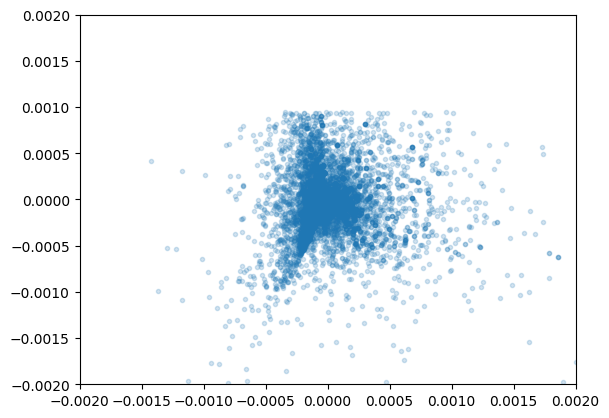

In [12]:
df_filtered = df_components[df_components[1]<(df_components[1].median()+.001)]
f,ax = plt.subplots(1,1)
ax.plot(df_filtered[0],df_filtered[1],'.',alpha=.2)
ax.set_xlim(-.002,0.002)
ax.set_ylim(-.002,0.002)

## Apply TSNE
T-distributed Stochastic Neighbor Embedding.

In [13]:
n_components = 2  # Number of components
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
tsne_result = tsne.fit_transform(tfidf_matrix_standardized)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [14]:
df_tsne = pd.DataFrame(tsne_result)
df_tsne.head()

,0,1
0,0.272885,-12.719827
1,2.883705,10.231670
2,5.392854,-25.062805
3,-4.788725,-11.857648
4,0.477470,6.457871


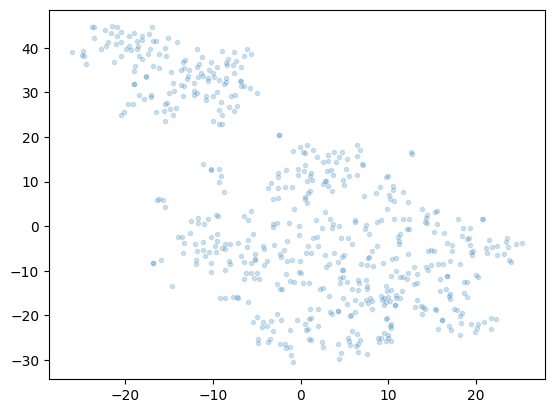

In [15]:
f,ax = plt.subplots(1,1)
ax.plot(df_tsne[0],df_tsne[1],'.',alpha=.2)

# Apply Gaussian Mixture Models (GMM) clustering

In [16]:
n_clusters = 8  # Number of clusters (you can adjust this)
gmm = GaussianMixture(n_components=n_clusters, random_state=0)
gmm_labels = gmm.fit_predict(tsne_result)

In [17]:
df_tsne['GMM'] = gmm_labels

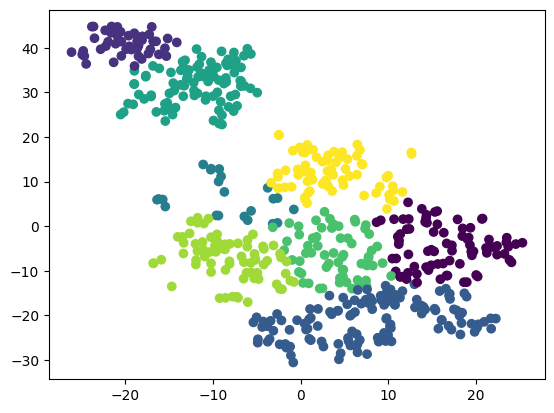

In [18]:
f,ax = plt.subplots(1,1)
ax.scatter(df_tsne[0],df_tsne[1],c=df_tsne['GMM'],cmap='viridis')

## Use BERT (LLM) to label the clusters (instead of TF-IDF)
<img src='https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png' width=400px>

In [19]:

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')



# Tokenize and convert abstracts to BERT embeddings
embeddings = []

for abstract in abstracts:
    inputs = tokenizer(abstract, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())

## Use Bert Embeddings to Classify

#### Now 'embeddings' contains BERT embeddings for each abstract

## Apply PCA on Bert embeddings

In [22]:
# Create a K-Means clustering model
kmeans = KMeans(n_clusters=4)  # Specify the number of clusters

# Fit the model to the embeddings
cluster_labels = kmeans.fit_predict(embeddings)

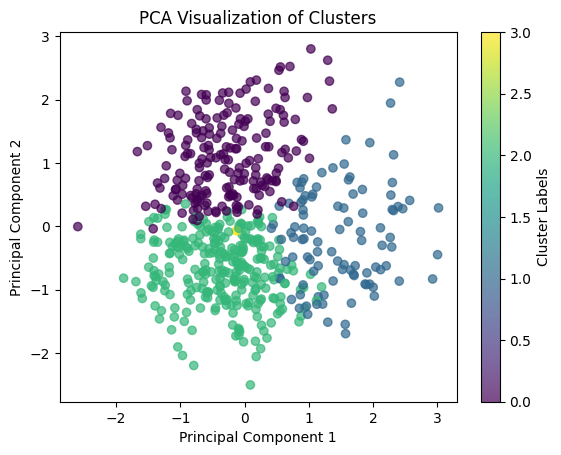

In [23]:
# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=3)
embeddings_2d = pca.fit_transform(embeddings)

# Create a scatter plot of the 2D embeddings with cluster labels
plt.scatter(embeddings_2d[:, 1], embeddings_2d[:, 0], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Labels')
plt.show()

## Generate Graph Links using Embeddings and Cosine Similarity

In [24]:
# Calculate cosine similarity between document embeddings
similarity_matrix = cosine_similarity(embeddings)
df_link_matrix = pd.DataFrame(similarity_matrix) ## Make pandas df from the similarity of each document

## Apply scale on the similarities

In [25]:
df_link_matrix_scaled = pd.DataFrame(scaler.fit_transform(df_link_matrix), columns=df_link_matrix.columns)

## Overview data

In [26]:
df_link_matrix_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
0,2.507184,0.711112,-0.571415,-1.115972,-0.052668,0.581660,-0.167549,0.665037,0.657566,0.815753,...,-1.010683,0.569153,0.445037,0.319995,-0.862700,-0.253118,-0.932869,-1.485639,-0.256096,-1.108145
1,0.678064,2.760105,-1.278680,-0.486000,-0.116350,-0.510527,-0.192191,0.370167,-0.203167,-0.257810,...,-0.598968,1.097994,0.817100,-0.220586,-0.851860,-0.197786,-0.739137,-1.161601,-0.843387,-0.332267
2,0.094614,-0.389003,3.709246,-0.309296,0.687183,0.531445,0.929616,0.323964,0.785813,0.476748,...,-0.267630,-0.456874,-0.789181,-0.354580,-0.386167,-0.310077,-0.110794,0.037196,-0.082081,0.113585
3,0.190844,0.555544,0.390769,3.073056,0.663950,0.830103,0.253235,0.254681,0.180977,0.442440,...,0.390979,0.159387,0.791229,0.667539,0.821785,0.665876,0.527182,0.495864,0.334847,0.234973
4,0.385801,0.336658,0.811221,0.091533,3.163106,0.302966,0.824980,0.885393,0.519971,0.449896,...,-0.084996,-0.394271,0.183495,-0.159448,-0.435191,-0.231204,-0.285996,-0.383638,0.025791,0.810676


## Use networkX and a similarity threshold to build the network

In [27]:
# Create an empty undirected graph
G = nx.Graph()

# Define the threshold for creating edges
threshold = 1.5

# Iterate over rows and columns to add edges with weights
for i, source_node in enumerate(df_link_matrix_scaled.columns):
    for j, target_node in enumerate(df_link_matrix_scaled.columns):
        if i < j:  # Only consider the upper triangle of the matrix
            weight = df_link_matrix_scaled.iloc[i, j]
            if weight >= threshold:
                G.add_edge(source_node, target_node, weight=weight)

## Export the network

In [28]:
# Specify the file path where you want to save the GEXF file
gexf_file_path = "Documents_graph.gexf"

# Export the graph to a GEXF file
nx.write_gexf(G, gexf_file_path)